# NEMO biases

In [11]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import xarray as xr
import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cmocean 
from scipy.stats import linregress

In [12]:
from dask.distributed import Client, LocalCluster, wait

In [13]:
cluster = LocalCluster(n_workers=4, threads_per_worker=2, memory_limit=16e9,
                       silence_logs=50)
client = Client(address=cluster)

/gxfs_home/geomar/smomw352/miniconda3/envs/py3_std/lib/python3.7/site-packages/distributed/node.py:164: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 46013 instead
  expected, actual


In [14]:
client

Client Scheduler: tcp://127.0.0.1:39589 Dashboard: http://127.0.0.1:46013/status,Cluster Workers: 4 Cores: 8 Memory: 59.60 GiB


## Read NEMO data

To make life easier we compute monthly climatology from NEMO first. 
```
cdo -ymonmean -select,startdate=2050-01-01T00:00:00,enddate=2550-01-01T00:00:00 ../../../outdata/nemo/FOCI_GJK029_1m_*_grid_T.nc FOCI_GJK029_ymonmean_20500101_25500101_grid_T.nc
```

Then re-grid to regular grid

```
cdo -remapbil,r720x360 -setctomiss,0 FOCI_GJK029_ymonmean_20500101_25500101_grid_T.nc FOCI_GJK029_ymonmean_20500101_25500101_grid_T_r720x360.nc
```

In [25]:
esmdir = '/gxfs_work1/geomar/smomw352/esm-experiments'
exp = 'FOCI_GJK029'
grid = 'grid_T'

file = '%s/%s/derived/nemo/ymonmean/%s_ymonmean_20500101_25500101_%s_r720x360.nc' % (esmdir, exp, exp, grid)
ds_monmean = xr.open_dataset(file, use_cftime=True).rename({'time_counter':'time'})

In [26]:
ds_monmean

<xarray.Dataset>
Dimensions:            (time: 12, bnds: 2, lon: 720, lat: 360, deptht: 46)
Coordinates:
  * time               (time) object 2549-01-16 12:00:00 ... 2549-12-16 12:00:00
  * lon                (lon) float64 0.0 0.5 1.0 1.5 ... 358.0 358.5 359.0 359.5
  * lat                (lat) float64 -89.75 -89.25 -88.75 ... 88.75 89.25 89.75
  * deptht             (deptht) float32 3.047 9.454 ... 5.625e+03 5.875e+03
Dimensions without coordinates: bnds
Data variables: (12/27)
    time_counter_bnds  (time, bnds) object ...
    deptht_bnds        (deptht, bnds) float32 ...
    votemper           (time, deptht, lat, lon) float32 ...
    vosaline           (time, deptht, lat, lon) float32 ...
    sosstsst           (time, lat, lon) float32 ...
    sosaline           (time, lat, lon) float32 ...
    ...                 ...
    hflx_ice           (time, lat, lon) float32 ...
    hflx_cal           (time, lat, lon) float32 ...
    somxl010           (time, lat, lon) float32 ...
    somixhgt           (time, lat, lon) float32 ...
    sowindsp           (time, lat, lon) float32 ...
    sobowlin           (time, lat, lon) float32 ...
Attributes:
    CDI:          Climate Data Interface version 1.9.9 (https://mpimet.mpg.de...
    Conventions:  CF-1.6
    name:         ../../outdata/nemo/FOCI_GJK029_1m_18500101_18591231_grid_T
    description:  ocean T grid variables
    title:        ocean T grid variables
    timeStamp:    2023-Feb-19 13:41:01 GMT
    uuid:         9aea798e-673f-4bad-b8fe-24923e2af68b
    history:      Thu Jun 01 15:50:02 2023: cdo -remapbil,r720x360 -setctomis...
    NCO:          netCDF Operators version 4.7.9 (Homepage = http://nco.sf.ne...
    CDO:          Climate Data Operators version 1.9.9 (https://mpimet.mpg.de...

## Read observations

In [43]:
# EN4 for T, S
ds_en4 = xr.open_dataset('data/EN4_TS_surface_1950_2014_ymonmean.nc')
ds_era5 = xr.open_dataset('data/E5_1950_2014_ymonmean_surface_heat_flux.nc')
ds_argo = xr.open_dataset('data/Argo_MLD.nc')

In [44]:
sst_o = ds_en4['temperature'].isel(depth=0).mean('time')
sss_o = ds_en4['salinity'].isel(depth=0).mean('time')
shf_o = (ds_era5['ssr'] + ds_era5['str'] + ds_era5['sshf'] + ds_era5['slhf']).mean('time')
mld_o = ds_argo['mld_da_mean'].mean('time')

## Plot surface biases

0,0: MLD
0,1: THF
1,1: SSS
1,0: SST

/gxfs_home/geomar/smomw352/miniconda3/envs/py3_std/lib/python3.7/site-packages/ipykernel_launcher.py:55: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations


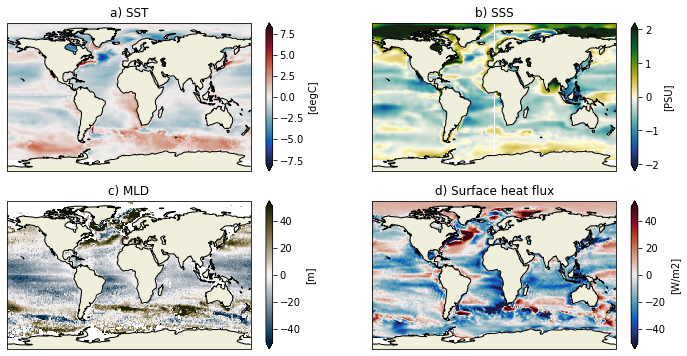

In [57]:
fig, axs1 = plt.subplots(2,2, figsize=(12,6), subplot_kw={'projection':ccrs.PlateCarree()})
ax1 = axs1.flat

## SST
vmax = 8
sst = ds_monmean['sosstsst'].mean('time')
sst_i = sst_o.interp_like(sst) - 273.15
(sst - sst_i).plot(ax=ax1[0], vmin=-vmax, vmax=vmax,
                   extend='both',
                   cbar_kwargs={'label':'[degC]'},
                   cmap=cmocean.cm.balance,
                   rasterized=True)

## SSS
vmax = 2
sss = ds_monmean['sosaline'].mean('time')
sss_i = sss_o.interp_like(sss)
(sss - sss_i).plot(ax=ax1[1], vmin=-vmax, vmax=vmax,
                   extend='both',
                   cbar_kwargs={'label':'[PSU]'},
                   cmap=cmocean.cm.delta,
                   rasterized=True)

## MLD
vmax = 50
mld = ds_monmean['somxl010'].mean('time')
mld = mld.assign_coords({"lon": (((mld.lon + 180) % 360) - 180)}).sortby('lon')
mld_i = mld_o.interp_like(mld)
(mld - mld_i).plot(ax=ax1[2], vmin=-vmax, vmax=vmax,
                   extend='both',
                   cbar_kwargs={'label':'[m]'},
                   cmap=cmocean.cm.diff,
                   rasterized=True)

## Surface heat flux
vmax = 50
shf = ds_monmean['sohefldo'].mean('time')
shf_i = shf_o.interp_like(shf)
(shf - shf_i).plot(ax=ax1[3], vmin=-vmax, vmax=vmax,
                   extend='both',
                   cbar_kwargs={'label':'[W/m2]'},
                   cmap=cmocean.cm.balance,
                   rasterized=True)

ax1[0].set_title('a) SST')
ax1[1].set_title('b) SSS')
ax1[2].set_title('c) MLD')
ax1[3].set_title('d) Surface heat flux')

for ax in ax1:
    ax.set_aspect('auto')
    ax.coastlines()
    ax.add_feature(cfeature.LAND)
    
fig.tight_layout()
fig.savefig('plots/nemo_surface_biases.pdf',format='pdf',dpi=150)

## References

* Mixed-layer depth: Holte, J., L. D. Talley, J. Gilson, and D. Roemmich (2017), An Argo mixed layer climatology and database, Geophys. Res. Lett., 44, 5618–5626, doi:10.1002/2017GL073426.
* EN4: Good, S. A., M. J. Martin and N. A. Rayner, 2013. EN4: quality controlled ocean temperature and salinity profiles and monthly objective analyses with uncertainty estimates, Journal of Geophysical Research: Oceans, doi:10.1002/2013JC009067.
* ERA5:  Hersbach, H, Bell, B, Berrisford, P, et al. The ERA5 global reanalysis. Q J R Meteorol Soc. 2020; 146: 1999– 2049. https://doi.org/10.1002/qj.3803